In [1]:
import numpy as np
from rdkit import Chem
import structure2sequence as struc2seq

print(struc2seq.__doc__)


File Name: structure2sequence.py
Author: Dingfeng Wu
Creator: Dingfeng Wu
Date Created: 2022-11-15
Last Modified: 2023-12-26
Version: 1.0.1
License: MIT License
Description: Structure-to-Sequence (Struc2seq) is a computing process based on RDkit and the characteristics of cyclic peptide sequences, which can convert cyclic peptide SMILES into sequence information.

Copyright Information: Copyright (c) 2023 dfwlab (https://dfwlab.github.io/)

The code in this script can be used under the MIT License.



In [2]:
examples = [('CP00291', 
             'CCC(C)[C@H](N)C1=NCC(C(=O)N[C@@H](CC(C)C)C(=O)N[C@H](CCC(=O)O)C(=O)N[C@H](C(=O)N[C@H]2CCCCNC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](CC(=O)O)NC(=O)[C@H](Cc3cnc[nH]3)NC(=O)[C@@H](Cc3ccccc3)NC(=O)[C@H](C(C)CC)NC(=O)[C@@H](CCCN)NC2=O)C(C)CC)S1', 
             'Unk-Leu-D-Glu-xiIle-Lys(1)-D-Orn-xiIle-D-Phe-His-D-Asp-Asn-(1)', 'Bacitracin A (8CI)'), 
            ('CP06079', 
             'CC[C@H](C)[C@@H]1NC(=O)[C@H](CCSC)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CS)NC(=O)[C@@H]2CCCN2C(=O)[C@H](CC(=O)O)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H]([C@@H](C)CC)NC(=O)[C@H](CS)NC(=O)[C@H]([C@@H](C)CC)NC(=O)[C@H](CS)NC(=O)[C@H](C)NC(=O)[C@H](CCSC)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CS)NC(=O)[C@H](C(C)C)NC(=O)CNC(=O)[C@H](C(C)C)NC(=O)[C@H](CS)NC(=O)[C@H](CS)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](Cc2c[nH]cn2)NC(=O)[C@H](CCCNC(=N)N)NC1=O', 
             'cyclo[DL-N(Me)Asp-DL-N(Me)Val-DL-N(Me)xiIle-Gly-DL-N(Me)Val-DL-Tyr(Me)-DL-OAla-DL-Pip-DL-N(Me)Val-DL-Val]', 
             'KK-1')
            ]

In [3]:
smiles = examples[1][1]
m = Chem.MolFromSmiles(smiles)

# 1. Using the RDKit function "Chem.MolToSequence" conversion

* Can convert peptide sequences with essential amino acids;
* Sequences containing modified or non-essential amino acids cannot be accurately identified;
* Suitable for linear peptides, unable to recognize the cyclization position of cyclic peptides;

In [4]:
m_renum, seq = struc2seq.mol2seq_for_essentialAA(m)
seq

'IRHTCCVGVCFLMACICIEQFDPCEM'

# 2. Custom Structure 2 Sequence Conversion Process

## 2.1. Identify peptide skeleton and renumber atoms

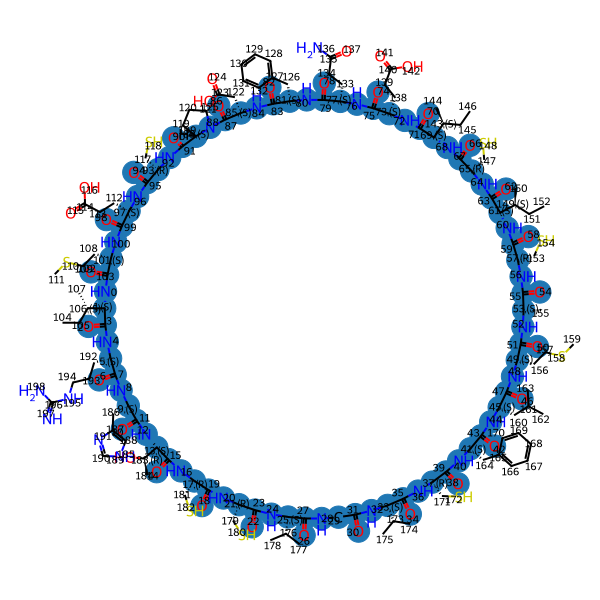

In [5]:
backbone_idx = struc2seq.detect_backbone(m)
m, backbone_idx = struc2seq.order_backbone(m, backbone_idx)
_ = struc2seq.highlight_atom(m, [backbone_idx])

## 2.2. Identify amino acid units

* Use minimum amino acid unit, GLY ('NCC=O '), to recognize amino acid position on peptide;
* Expand the branched chain to obtain complete amino acid units;
* Amino acid units may overlap, especially at the position of ring formation;

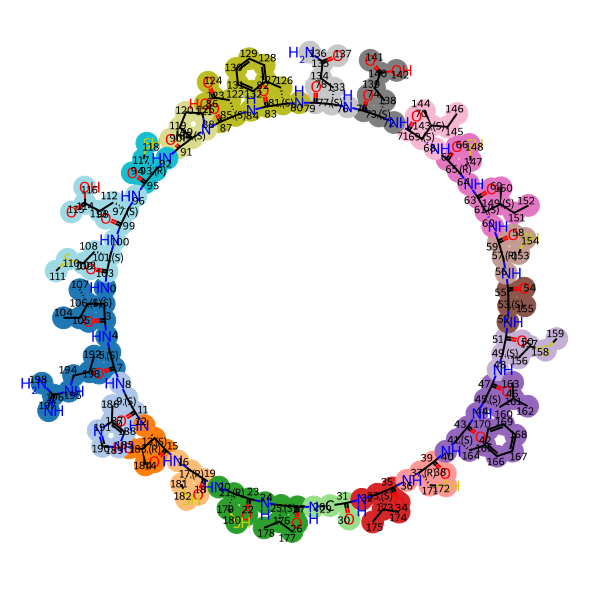

In [6]:
aa_units = struc2seq.split_aa_unit(m)
_ = struc2seq.highlight_atom(m, aa_units, transparency=0.5)

## 2.3. Obtain complete amino acid structures

In [7]:
aas, atom_mappings = struc2seq.get_complete_aas(m, aa_units)

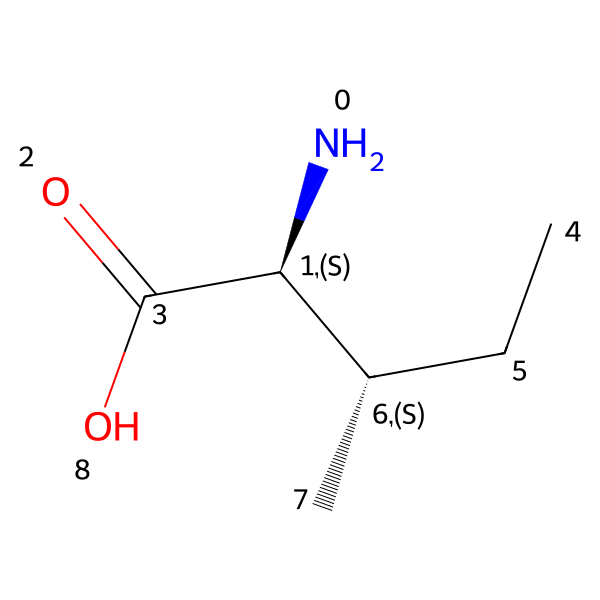

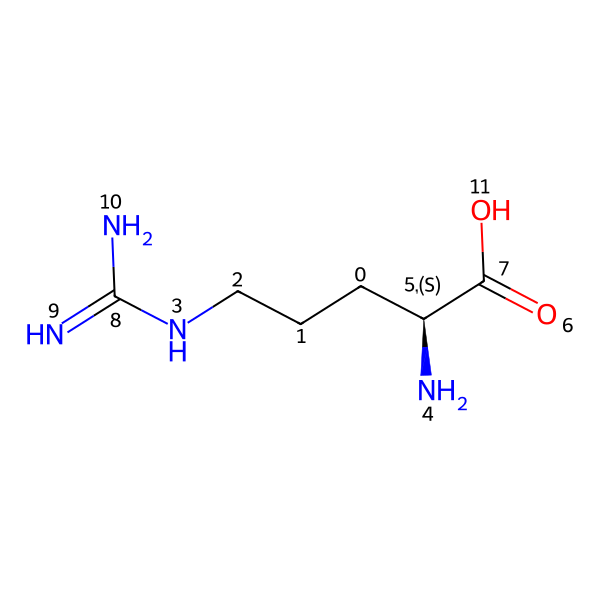

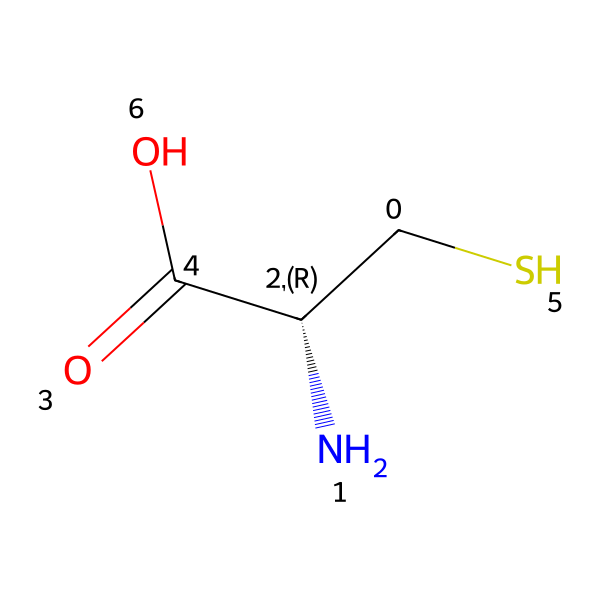

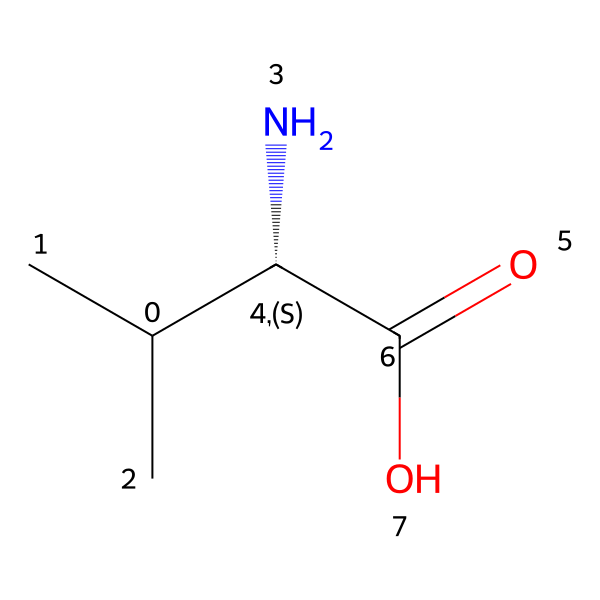

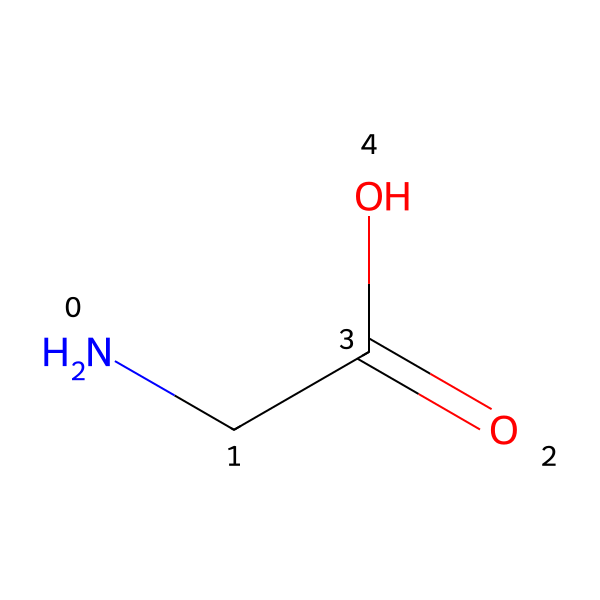

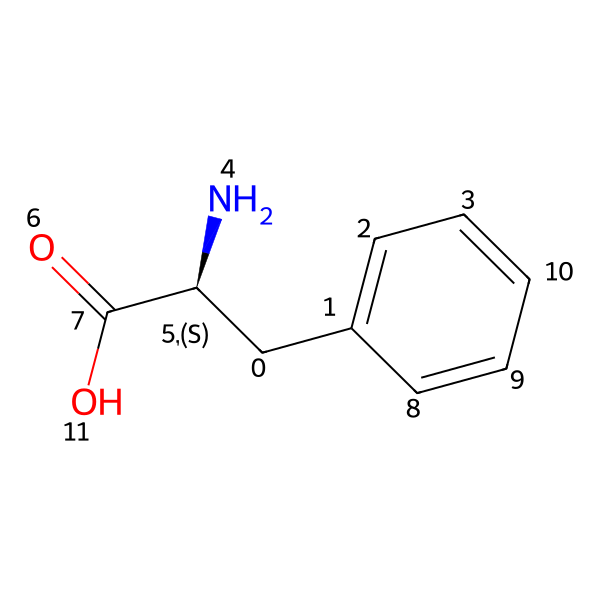

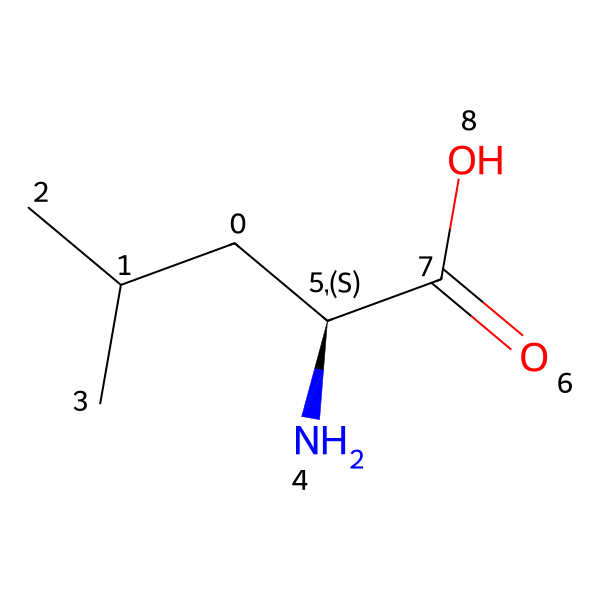

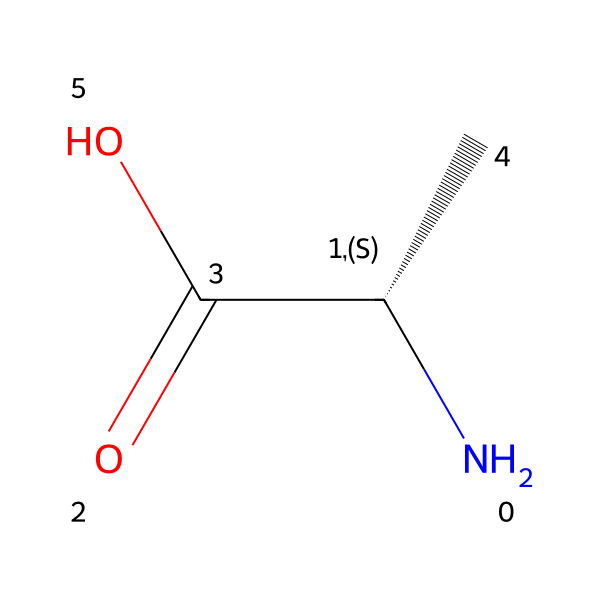

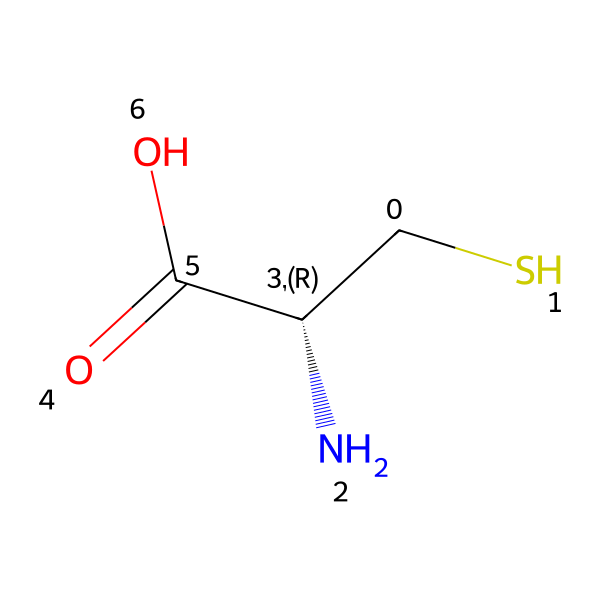

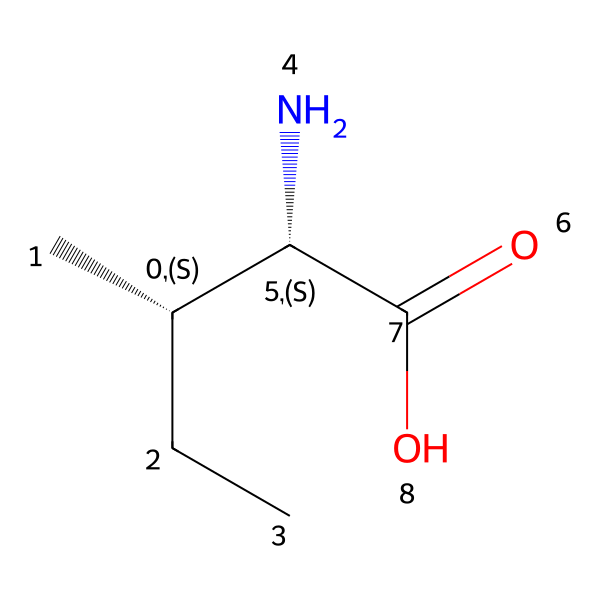

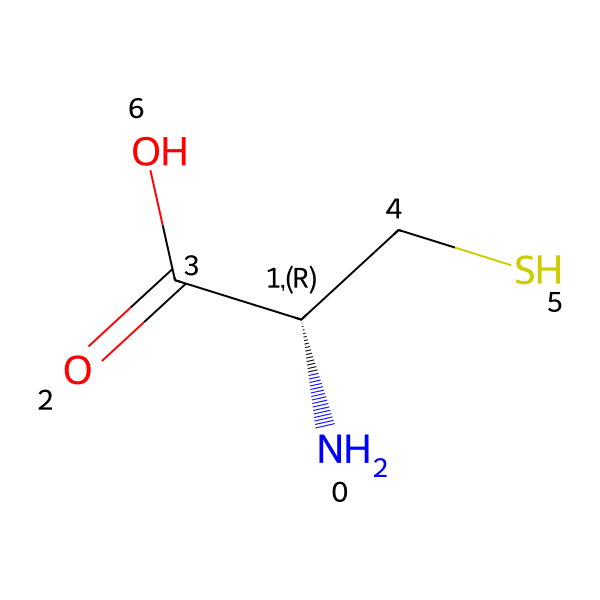

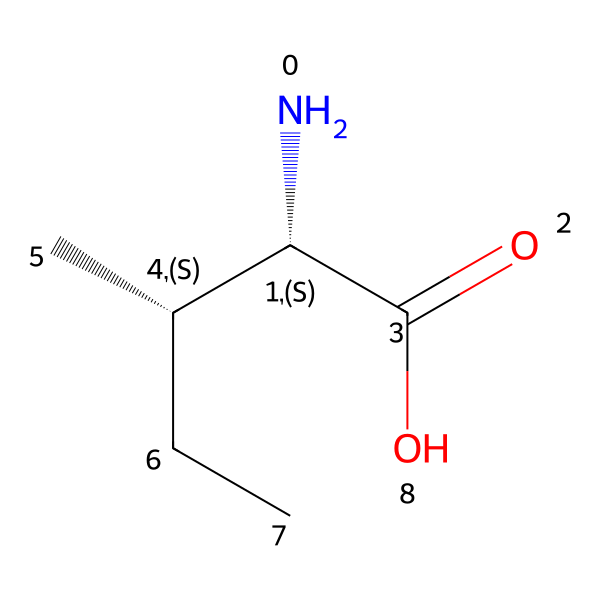

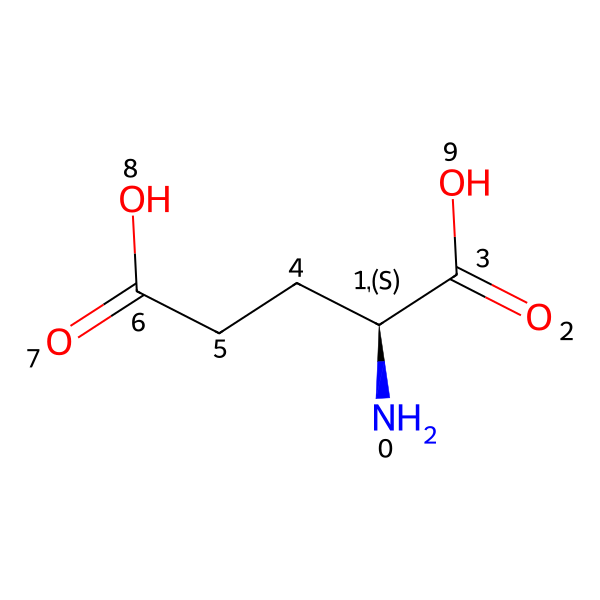

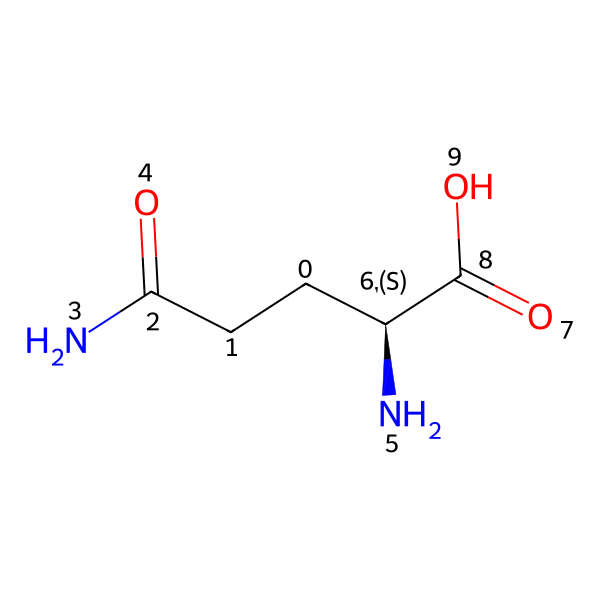

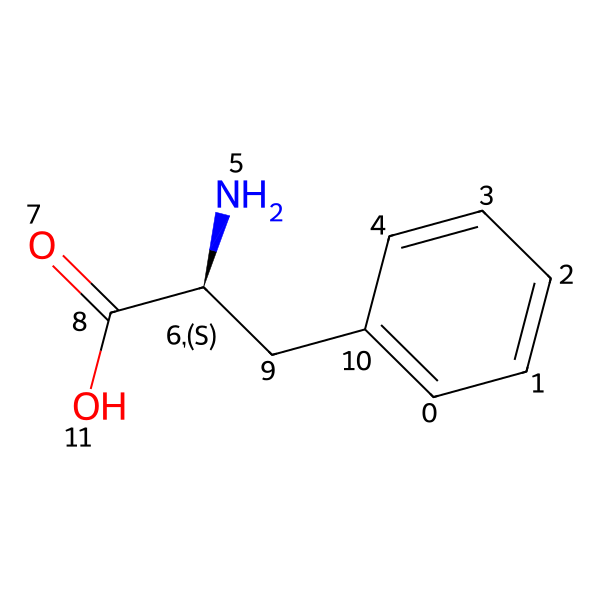

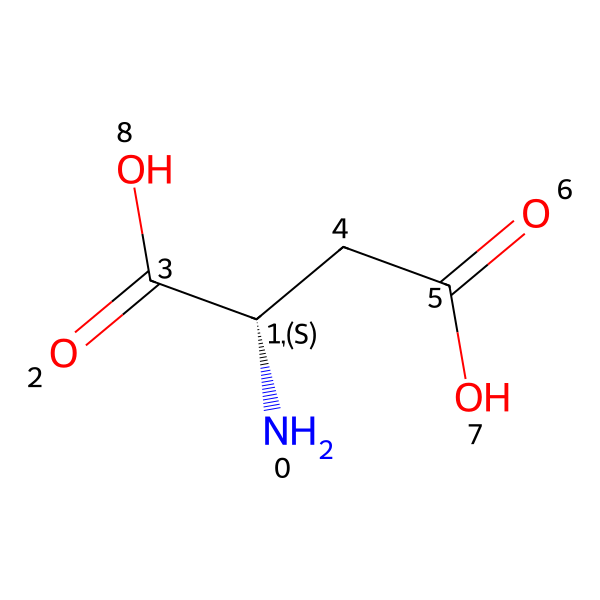

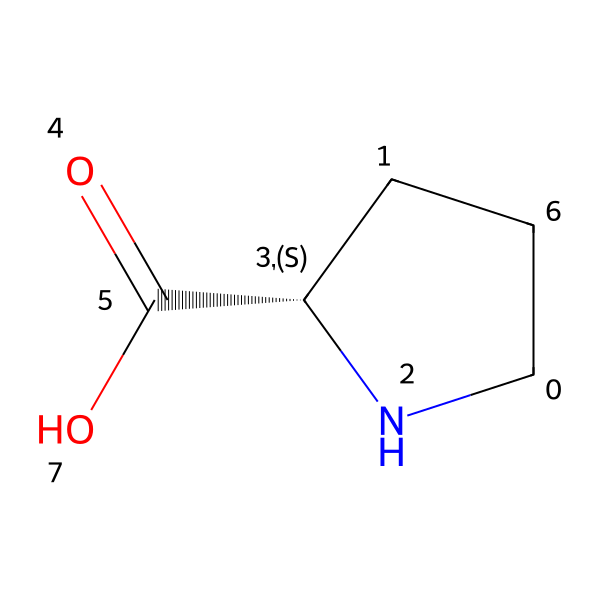

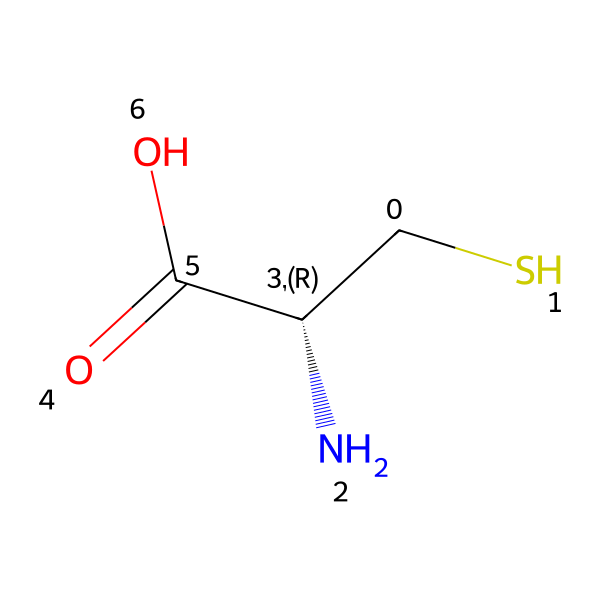

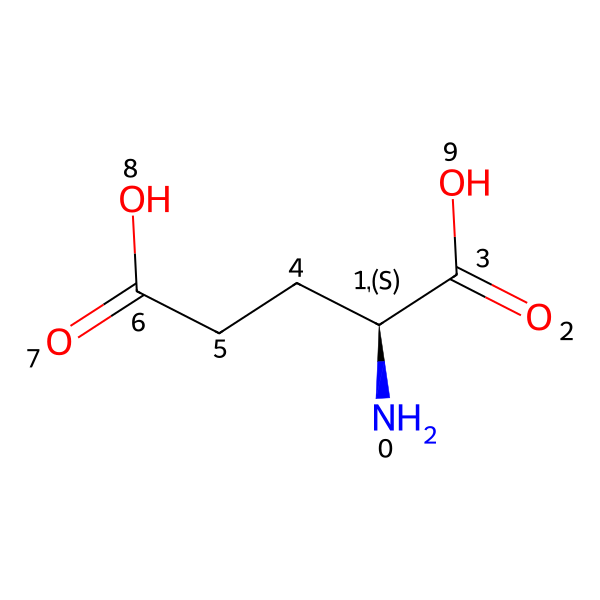

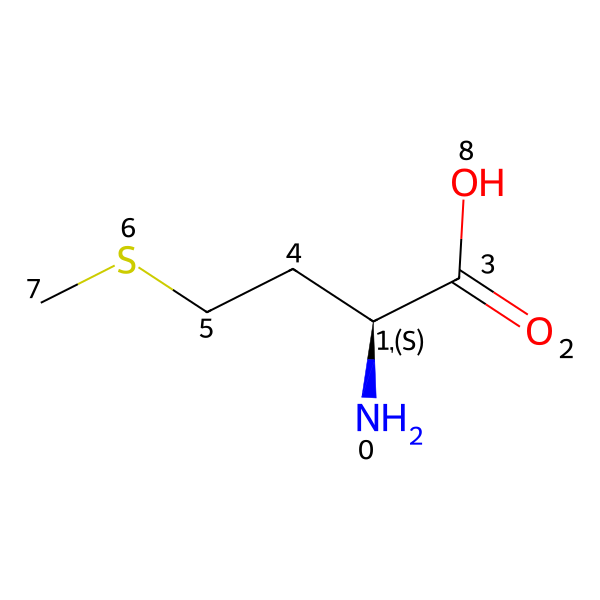

In [8]:
for aa in aas:
    _ = struc2seq.highlight_atom(aa, [[]])

## 2.4. Identify amino acids based on the monomer reference library

* 1. Identify the type of each amino acid unit;
* 2. If it can be directly recognized by 20 essential amino acids, then the amino acid can be directly determined;
* 3. If it cannot be directly recognized by essential amino acids, use library to find the maximum matching reference unit;
* 4. For cross amino acid units, select the two reference units with the most matching atoms and no cross;
* 5. If there are multiple best matched amino acid units, it may lead to different peptide chains;
* 6. Please note that some amino acids cannot be fully matched, users can view detailed information from the results;

In [9]:
ref_essentials, ref_others = struc2seq.reference_aa_monomer(path='monomer.tsv')
print(len(ref_essentials), len(ref_others))

connected_pairs = struc2seq.get_connected_pairs(m, atom_mappings)
chains = struc2seq.aa_matching(aas, atom_mappings, connected_pairs, ref_essentials, ref_others)
print(len(chains), connected_pairs)

for chain in chains:
    _ = struc2seq.highlight_atom(m, [i[5] for i in chain])

20 544
1 [(0, 1, 'peptide bond'), (0, 25, 'peptide bond'), (1, 2, 'peptide bond'), (2, 3, 'peptide bond'), (3, 4, 'peptide bond'), (4, 5, 'peptide bond'), (5, 6, 'peptide bond'), (6, 7, 'peptide bond'), (7, 8, 'peptide bond'), (8, 9, 'peptide bond'), (9, 10, 'peptide bond'), (10, 11, 'peptide bond'), (11, 12, 'peptide bond'), (12, 13, 'peptide bond'), (13, 14, 'peptide bond'), (14, 15, 'peptide bond'), (15, 16, 'peptide bond'), (16, 17, 'peptide bond'), (17, 18, 'peptide bond'), (18, 19, 'peptide bond'), (19, 20, 'peptide bond'), (20, 21, 'peptide bond'), (21, 22, 'peptide bond'), (22, 23, 'peptide bond'), (23, 24, 'peptide bond'), (24, 25, 'peptide bond')]


## 2.5. Draw conversion results

Ile(1)--Orn--His--Thr--Cys--Cys--Val--Gly--Val--Cys--Phe--Leu--Met--Ala--Cys--Ile--Cys--Ile--Glu--Gln--Phe--Asp--Pro--Cys--Glu--Met(1)


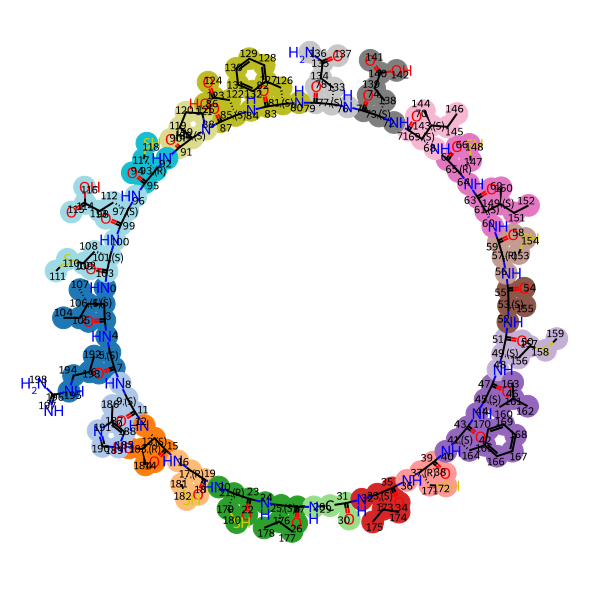

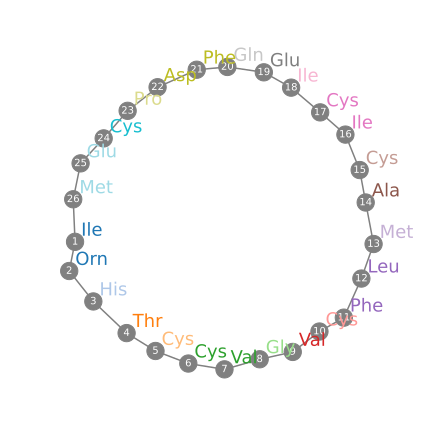

In [10]:
for chain in chains:
    print(struc2seq.sequence_str(chain, connected_pairs))
    _ = struc2seq.highlight_atom(m, [i[5] for i in chain])
    struc2seq.sequence_map(m, aa_units, chain, connected_pairs)

## 2.6. Check the result

* Peptide chains is basically consistent to the original provided accurate peptide chains;
* The recognition of amino acid number 4 is OH-Pro, with the original being Pro;
* There is indeed an additional -OH group in the structure of amino acid 4;
* Although the recognition of amino acid number 5 (Ile) is consistent with the original sequence, there are actually two -OH modifications on this amino acid;

Proline (Pro):


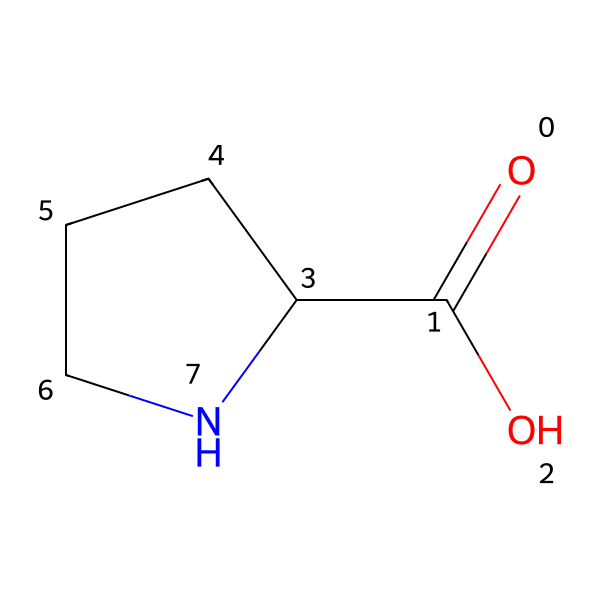

In [11]:
print('Proline (Pro):')
_ = struc2seq.highlight_atom(ref_essentials['Pro'][0], [[]])

Amino acid 4:


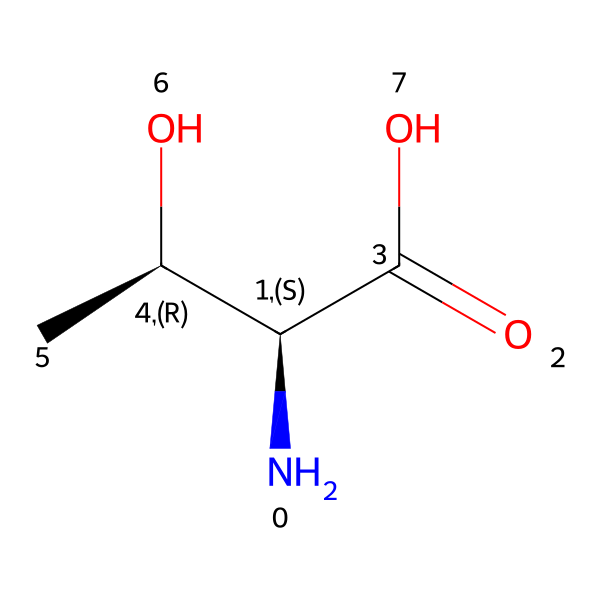

In [12]:
print('Amino acid 4:')
_ = struc2seq.highlight_atom(aas[3], [[]])

# 3. Transform and report generation through an integrated function

In [13]:
from IPython.display import HTML

html = struc2seq.transform(smiles, path='monomer.tsv')
# show html report
HTML(html)